# Fit atmosphere parameters

- author Sylvie Dagoret-Campagne
- update August 17th 2020


BAD FIT ALL AT SAME TIME

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
DATADIR="../../data/atm"

In [4]:
atmospheric_basename_files=os.listdir(DATADIR)

In [5]:
atmospheric_basename_files

['lsst_atm_10year_bintab.parquet',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [6]:
input_file=os.path.join(DATADIR,'lsst_atm_10year_bigimg.fits')

In [7]:
hdu = fits.open(input_file)

In [8]:
hdr=hdu[0].header
data=hdu[0].data

In [9]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                 3651                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [10]:
#NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [11]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

In [12]:
# Extract wavelength Wavelength
wl=data[0,idx_out_res:]
transm=data[1:,idx_out_res:]

In [13]:
NWL=wl.shape[0]

In [14]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data

In [15]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

## Fit VAOD,PWV, Ozone

In [16]:
Y=np.concatenate((vaodarr,pwvarr,o3arr),axis=1)

In [17]:
X=transm

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [19]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Linear regression model

In [20]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
reg = linear_model.LinearRegression()

In [22]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [23]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
Y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.5f'
      % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.5f'
      % r2_score(Y_test, Y_pred))


Coefficients: 
 [[-7.82884241e+07  1.94279313e+08  8.82124296e+06 ...  3.66937449e+00
   4.61822485e+00  1.56050607e+00]
 [-3.87690997e+08  9.62087837e+08  4.36835525e+07 ...  1.05088817e+02
   1.09787605e+02  1.99416895e+02]
 [-2.23689194e+11  5.55103560e+11  2.52044507e+10 ...  6.80772557e+03
   9.51882334e+03 -3.09396317e+02]]
Mean squared error: 0.00006
Coefficient of determination: 1.00000


# Linear Regression with Ridge

In [24]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=.5)

In [25]:
# Train the model using the training sets
regr_ridge.fit(X_train, Y_train)

# Make predictions using the testing set
Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)
# The mean squared error
print('Mean squared error: %.5f'
      % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.5f'
      % r2_score(Y_test, Y_pred))

Ridge(alpha=0.5)
Coefficients: 
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.82685498e-04
   3.82685498e-04  2.65670878e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -9.08940789e-01
  -9.08940789e-01 -5.40092715e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.78055977e-01
   1.78055977e-01  6.58050521e-01]]
Mean squared error: 2.84387
Coefficient of determination: 0.99211


## Tune hyper parameter with Ridge

In [26]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    ridge.fit(X_train,Y_train)
    coefs.append(ridge.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred = ridge.predict(X_val)
    MSE=mean_squared_error(Y_val, Y_pred)
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

<Figure size 1080x1080 with 0 Axes>

In [27]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [28]:
alpha_ridge=alphas[idx_min]
alpha_ridge

1e-10

2.0022003718155846e-06

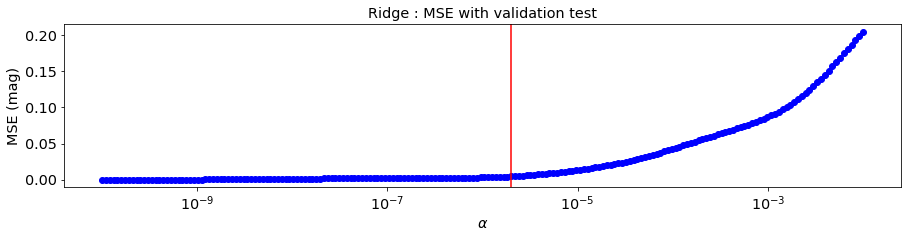

In [29]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
idx_min=np.where(all_MSE<0.005)[0][-1]
alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE (mag)")
ax.set_title("Ridge : MSE with validation test")
alpha_ridge

### Display results

Text(0.5, 1.0, 'Ridge : MSE with validation test')

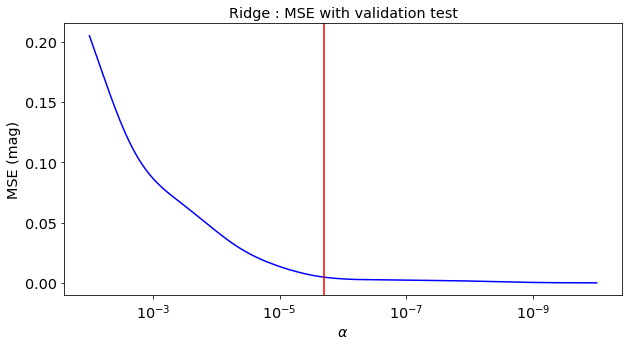

In [30]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE (mag)")
ax.set_title("Ridge : MSE with validation test")

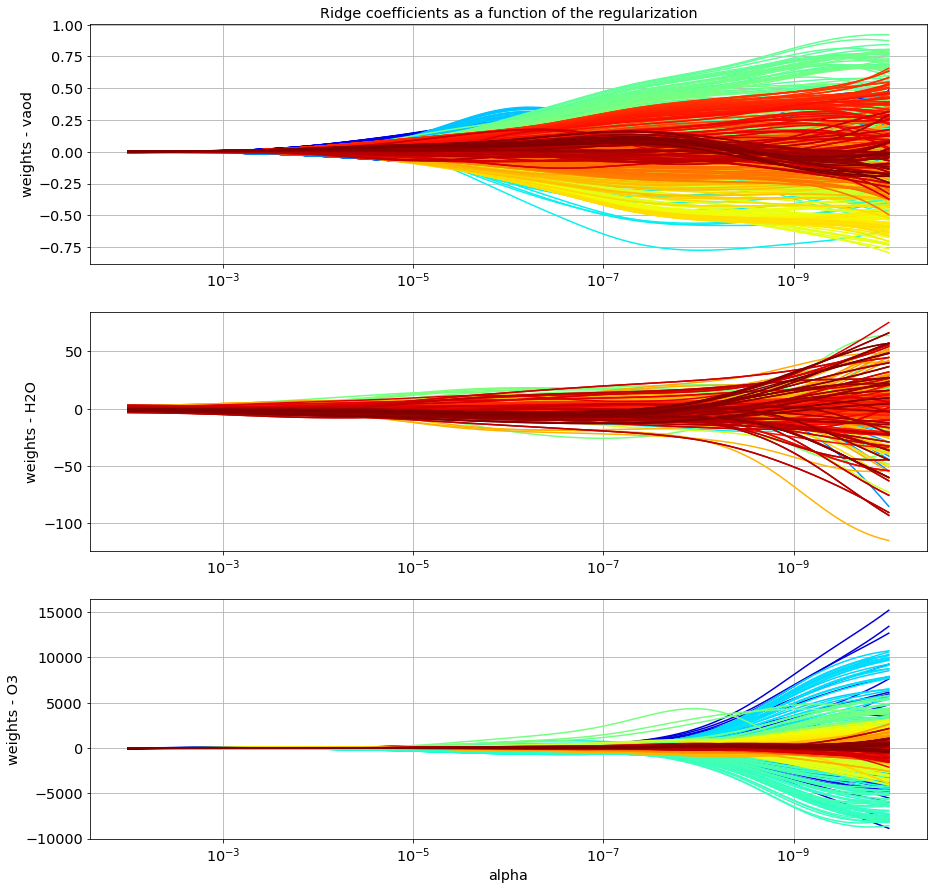

In [31]:
fig=plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(311)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Ridge coefficients as a function of the regularization')

ax2 = fig.add_subplot(312,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(313,sharex=ax2)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [32]:
from sklearn import linear_model

In [33]:
regr_lasso = linear_model.Lasso(alpha=0.1)

In [34]:
regr_lasso.fit(X_train, Y_train)

Lasso(alpha=0.1)

In [35]:
Y_pred_lasso = regr_lasso.predict(X_test)
r2_score_lasso = r2_score(Y_test, Y_pred_lasso)
print(regr_lasso)
print("r^2 on test data : %f" % r2_score_lasso)

Lasso(alpha=0.1)
r^2 on test data : 0.467338


In [36]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -2, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    lasso.fit(X_train,Y_train);
    coefs.append(lasso.coef_)
    
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
    lasso2.fit(X_train,Y_train);
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred = lasso.predict(X_val)
    MSE=mean_squared_error(Y_val, Y_pred)
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014557237268486868, tolerance: 6.827677555150155e-05
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 794.0604682720242, tolerance: 78.82143125410543
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3371435186707825, tolerance: 0.0006826444834332756
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001101312287070518, tolerance: 6.827677555150155e-05
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 927.3893038091518, tolerance: 78.82143125410543
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34127362405545736, tolerance: 0.0006826444834332756
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33999078632680846, tolerance: 0.0006826444834332756
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.9017372680311, tolerance: 17.67583331809439
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111290.13381271856, tolerance: 16293.445710033671
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101882.37055474216, tolerance: 16293.445710033671
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.374682570819147, tolerance: 3.2251298292582407
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.1779311621967, tolerance: 78.82143125410543
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

<Figure size 1080x1080 with 0 Axes>

2.976351441631313e-05

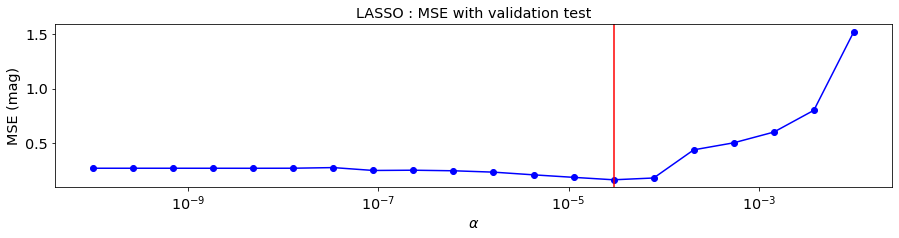

In [37]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
idx_min=np.where(all_MSE==all_MSE.min())[0][0]
alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE (mag)")
ax.set_title("LASSO : MSE with validation test")
alpha_lasso

Text(0.5, 1.0, 'LASSO : MSE with validation test')

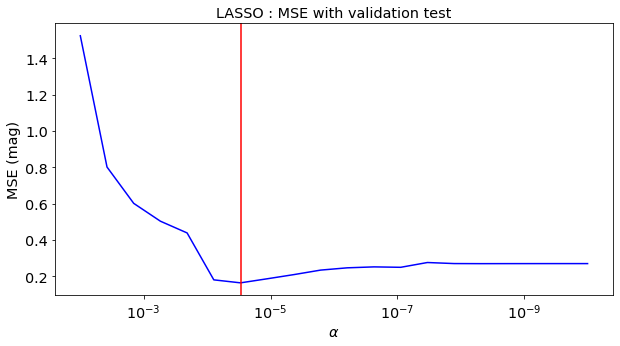

In [38]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE (mag)")
ax.set_title("LASSO : MSE with validation test")

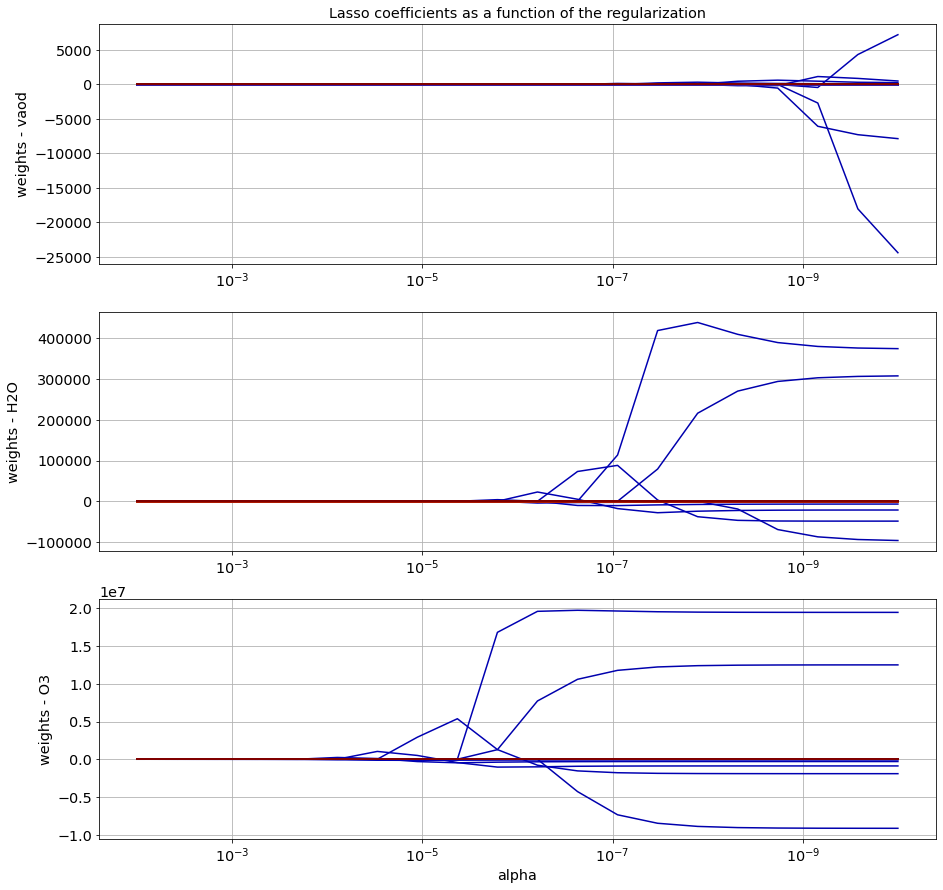

In [39]:
fig=plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(311)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Lasso coefficients as a function of the regularization')

ax2 = fig.add_subplot(312,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(313,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Verification with test  set

In [40]:
ridge = linear_model.Ridge(alpha=alpha_ridge, fit_intercept=True)
ridge.fit(X_train,Y_train)
ridge_coefs=ridge.coef_
    
# calculate metric
# Make predictions using the testing set
Y_pred = ridge.predict(X_test)
MSE_ridge=mean_squared_error(Y_test, Y_pred)

In [53]:
ridge_coefs

array([[ 0.        ,  0.        ,  0.        , ...,  0.04230238,
         0.04230238,  0.04311506],
       [ 0.        ,  0.        ,  0.        , ..., -5.13742703,
        -5.13742703, -3.69910259],
       [ 0.        ,  0.        ,  0.        , ..., 33.73143555,
        33.73143555, 16.85004081]])

In [41]:
MSE_ridge

0.0047868607007227676

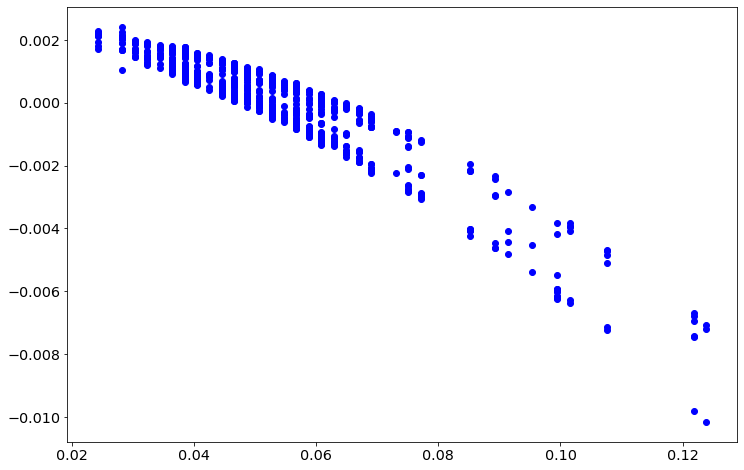

In [50]:
plt.plot(Y_test[:,0],Y_pred[:,0]-Y_test[:,0],"bo")

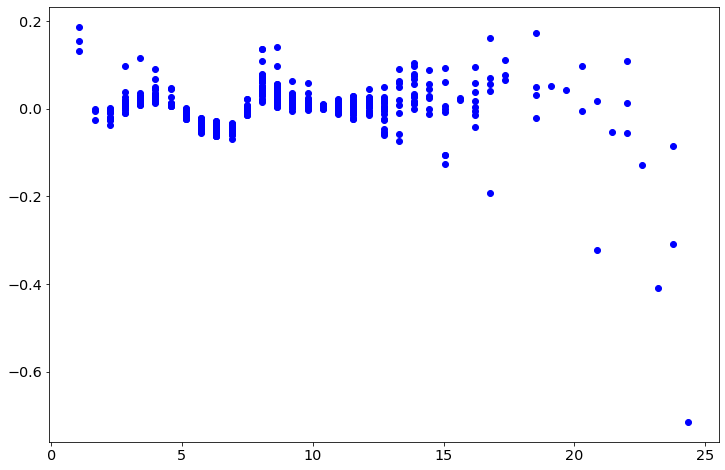

In [51]:
plt.plot(Y_test[:,1],Y_pred[:,1]-Y_test[:,1],"bo")

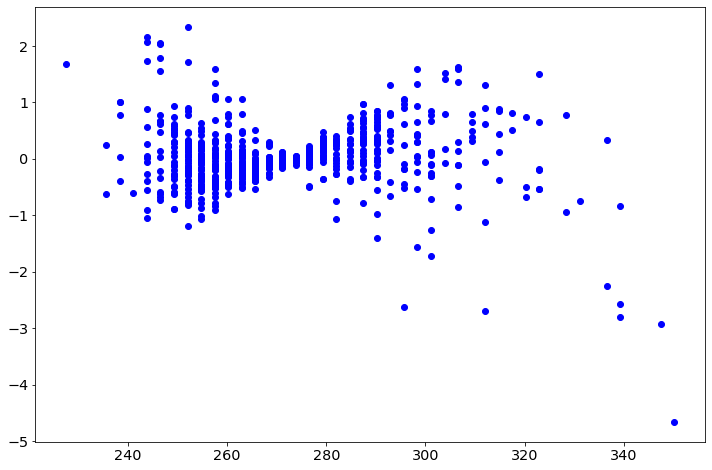

In [52]:
plt.plot(Y_test[:,2],Y_pred[:,2]-Y_test[:,2],"bo")

In [42]:
lasso = linear_model.Lasso(alpha=alpha_lasso, fit_intercept=True)
lasso.fit(X_train,Y_train)
lasso_coefs=lasso.coef_
    
# calculate metric
# Make predictions using the testing set
Y_pred = lasso.predict(X_test)
MSE_lasso=mean_squared_error(Y_test, Y_pred)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023524493235272184, tolerance: 6.827677555150155e-05
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.722827957294935, tolerance: 3.2251298292582407
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1189.0381345555804, tolerance: 78.82143125410543
  positive)


In [43]:
MSE_lasso

0.11583949581424774